# Assignment 9: Development of a tracking filter of a moving object when measurements and motion models are in different coordinate systems.

## Team №6:
1. Angelina Prokopeva
2. Nikita Gorbadey
3. Mark Griguletskii
4. Stanislav Savushkin

03.10.2019, Skoltech

In [45]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Image
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [46]:
generate_report = False
def plot(trace_num, x_data, y_data, xlable = 'xlable', ylable = 'ylable',
                legend = 'legend', title = 'title', mode='lines'):
    plot.counter += 1
    fig_name = 'images/' + str(plot.counter) + '.jpg'
    fig = go.Figure()
    for i in range(trace_num):
        fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode=mode, name=legend[i], showlegend = True))
    fig.update_layout(
        title=go.layout.Title(
            text=title,
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text=xlable
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text=ylable
            )
        )
    )
    if generate_report is True:
        fig.write_image(fig_name)
        display(Image(fig_name))
    else:
        fig.show()
plot.counter = 0

In [47]:
def plot_polar(trace_num, r, theta, xlable = 'xlable', ylable = 'ylable',
                legend = 'legend', title = 'title', mode='lines', size=500):
    fig = go.Figure()
    r_min = np.min(r[0])
    r_max = np.max(r[0])
    for i in range(trace_num):
        fig.add_trace(go.Scatterpolar(r = r[i], theta = theta[i], mode=mode[i],
                                      name=legend[i], showlegend = True))
        if r_min > np.min(r[i]):
            r_min = np.min(r[i])
        if r_max < np.max(r[i]):
            r_max = np.max(r[i])
    fig.update_layout(
        width=size,
        height=size,
        title=go.layout.Title(
                text=title,
            ),
        polar = dict(
            radialaxis = dict(range=[r_min*0.99, r_max*1.01])
            )
        )
    fig.show()

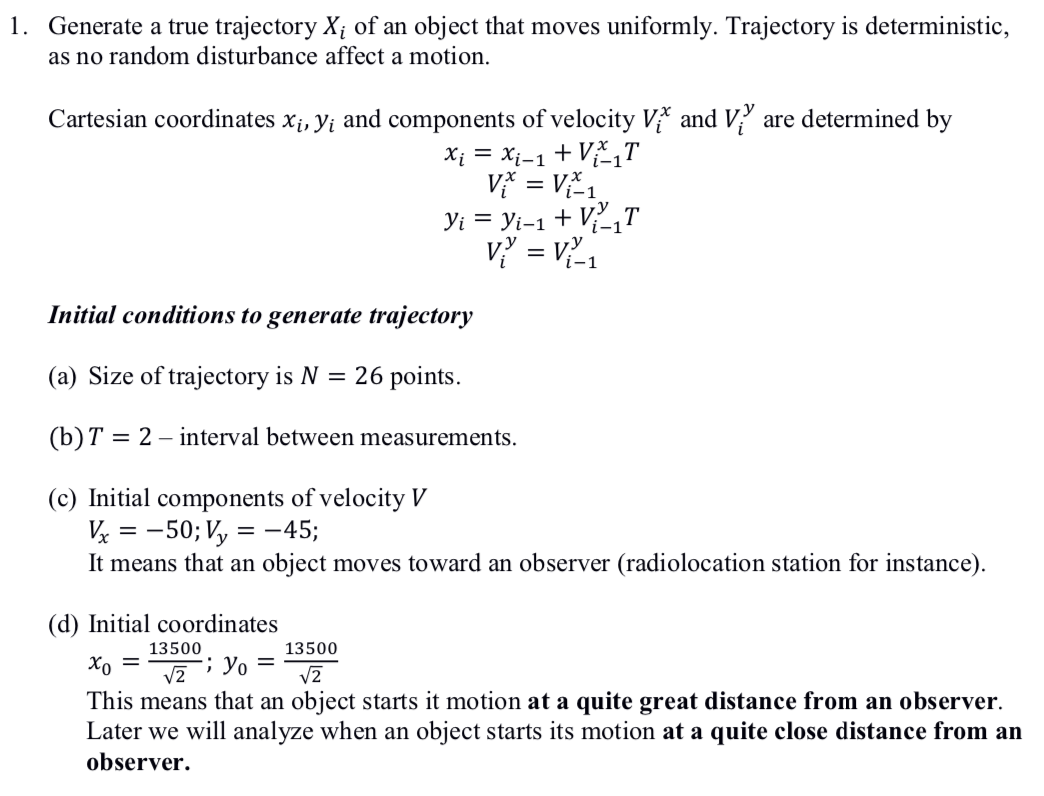

In [48]:
def generate_trajectory(n=26, T=2, Vx_init=-50, Vy_init=-45, x0=13500/np.sqrt(2), y0=13500/np.sqrt(2)):
    x = np.zeros(n)
    y = np.zeros(n)
    Vx = np.full(n, Vx_init)
    Vy = np.full(n, Vy_init)
    x[0] = x0
    y[0] = y0
    x[1:] = Vx[:-1]*T
    y[1:] = Vy[:-1]*T
    return [np.cumsum(x), Vx, np.cumsum(y), Vy]

In [5]:
N = 26
x, Vx, y, Vy = generate_trajectory()
steps = np.linspace(1, N, num=N)

In [6]:
plot(1, [x], [y], legend=['True trajectory'])

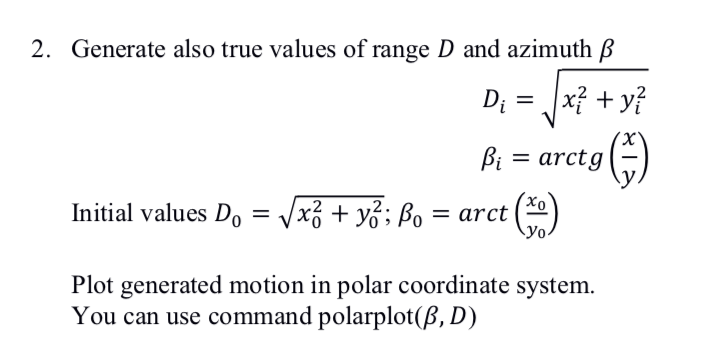

In [7]:
def cortes2polar(x, y):
    return [np.sqrt(x[:]**2 + y[:]**2), np.arctan2(x[:], y[:])]

In [8]:
D, beta = cortes2polar(x, y)
plot_polar(1, [D], [np.degrees(beta)], legend=['true trajectory'], mode=['lines'])

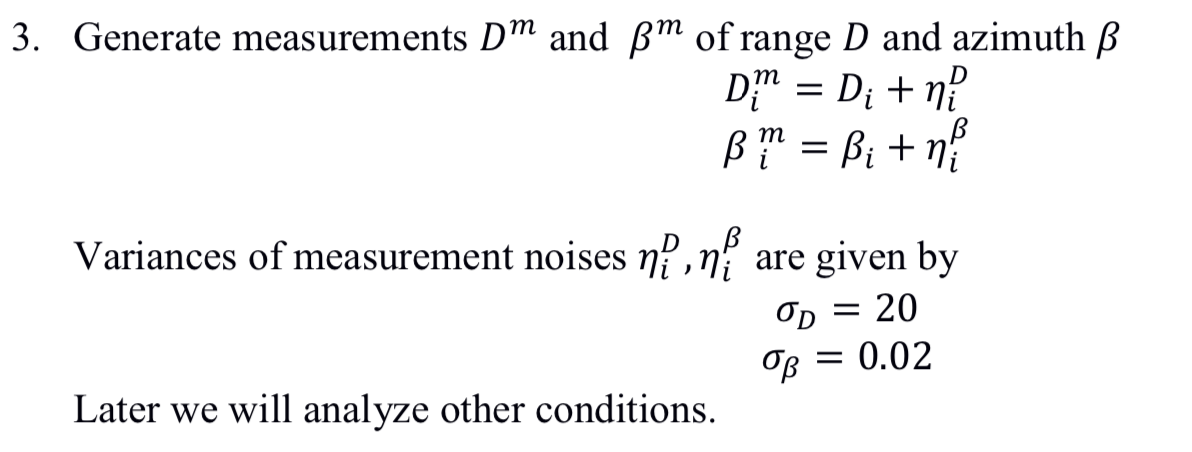

In [9]:
def measure_polar_coord(D, beta, sigma_D=20, sigma_b=0.02):
    return [D+np.random.normal(loc=0, scale=sigma_D, size=D.size),
            beta+np.random.normal(loc=0, scale=sigma_b, size=beta.size)]

In [10]:
D_mes, beta_mes = measure_polar_coord(D, beta)
plot_polar(2, [D, D_mes], [np.degrees(beta), np.degrees(beta_mes)],
           legend=['true tr', 'measured tr'], mode=['lines', 'lines'])

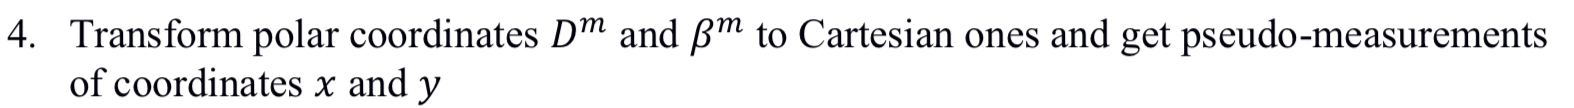

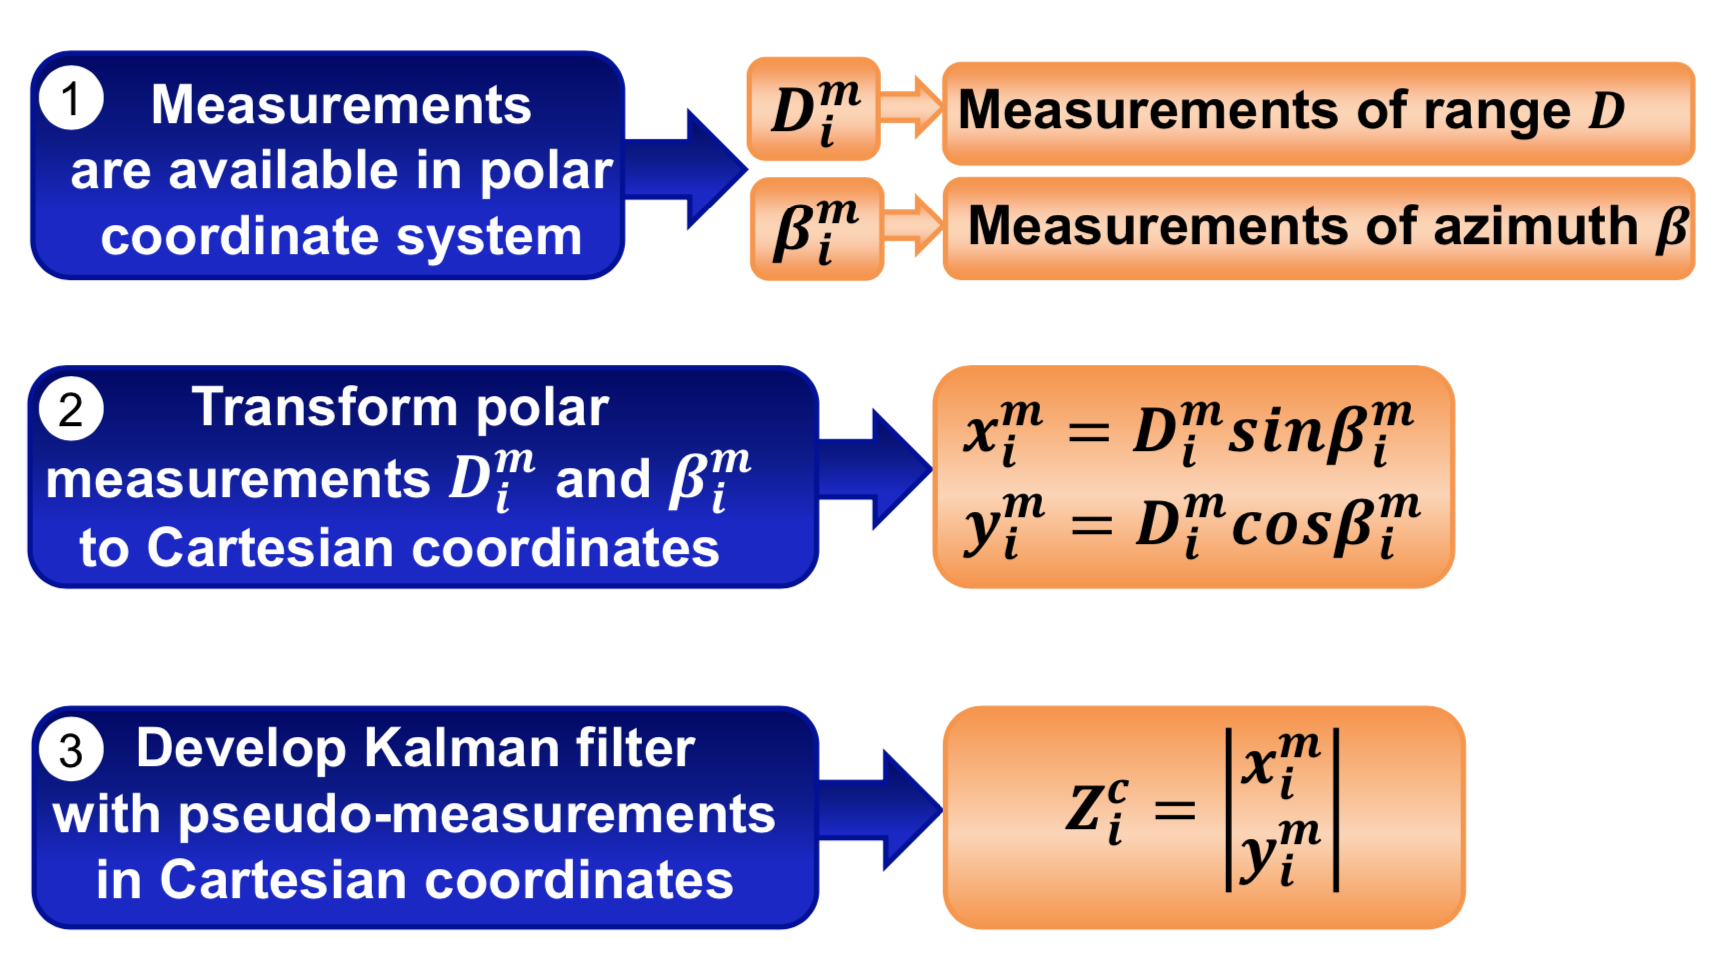

In [11]:
def polar2cartes(D, beta):
    return D[:]*np.sin(beta[:]), D[:]*np.cos(beta[:])

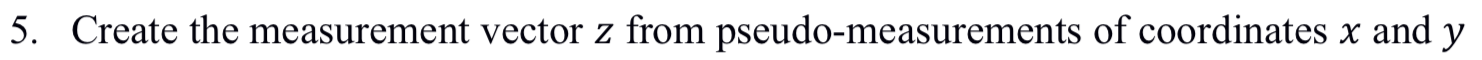

In [14]:
z = np.column_stack(polar2cartes(D_mes, beta_mes))
plot(2, [x, z[:, 0]], [y, z[:, 1]], legend=['true tr', 'pseudo mes tr'],
     title='Trajectrory', xlable='X', ylable='Y', mode=['lines', 'lines'])

ValueError: 
    Invalid value of type 'builtins.list' received for the 'mode' property of scatter
        Received value: ['lines', 'lines']

    The 'mode' property is a flaglist and may be specified
    as a string containing:
      - Any combination of ['lines', 'markers', 'text'] joined with '+' characters
        (e.g. 'lines+markers')
        OR exactly one of ['none'] (e.g. 'none')

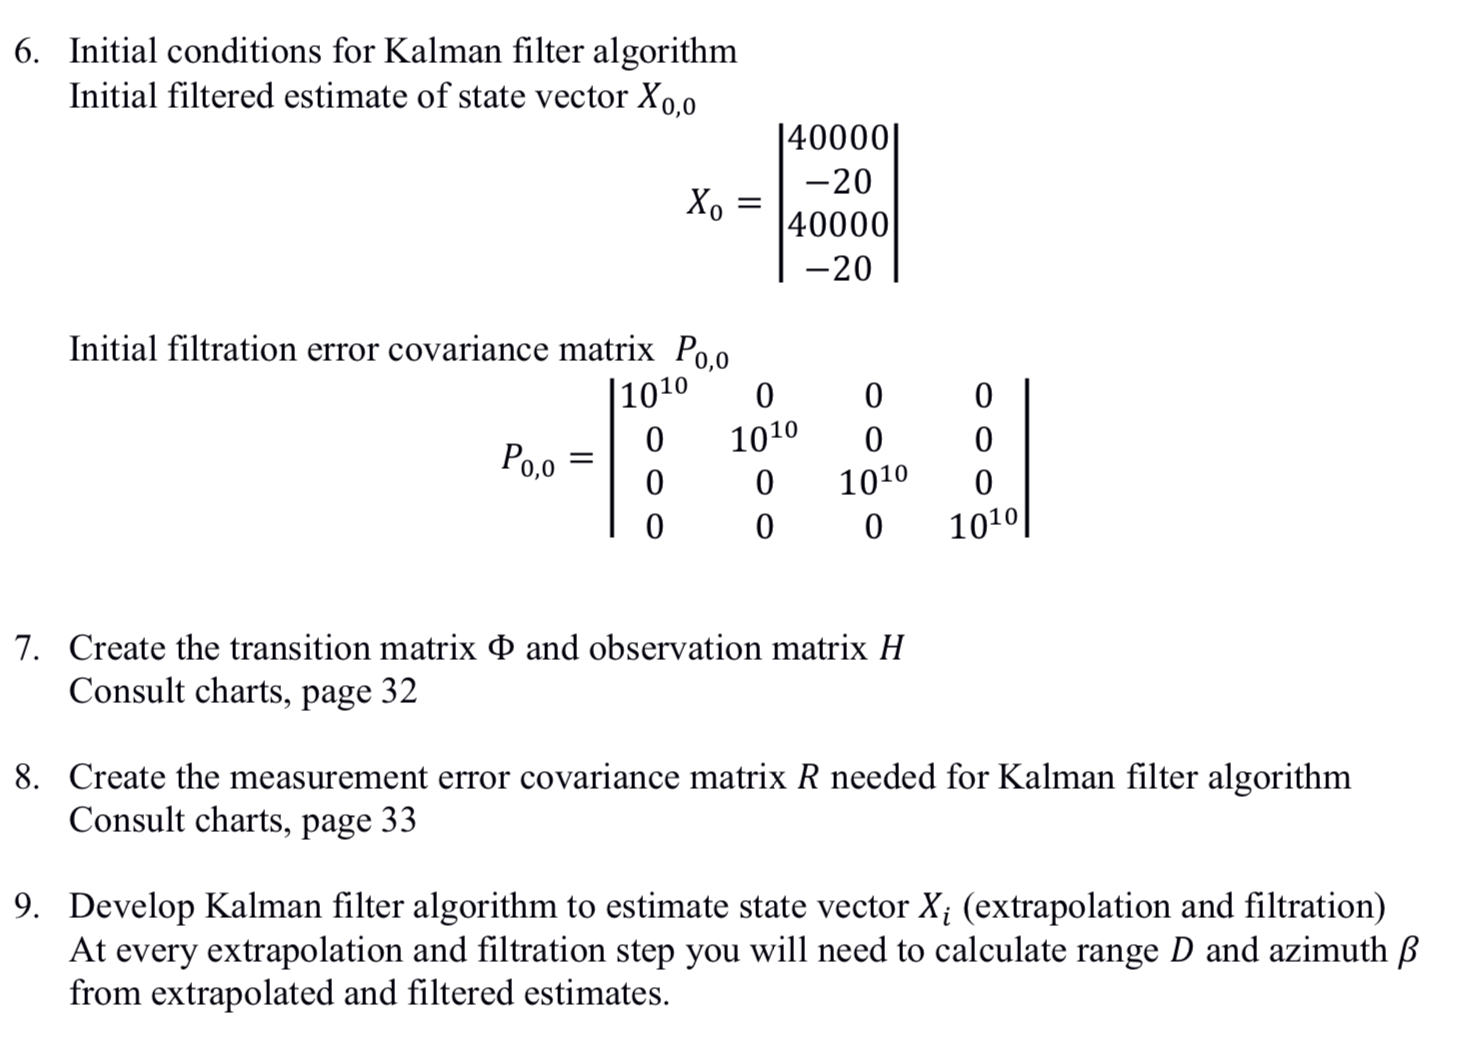

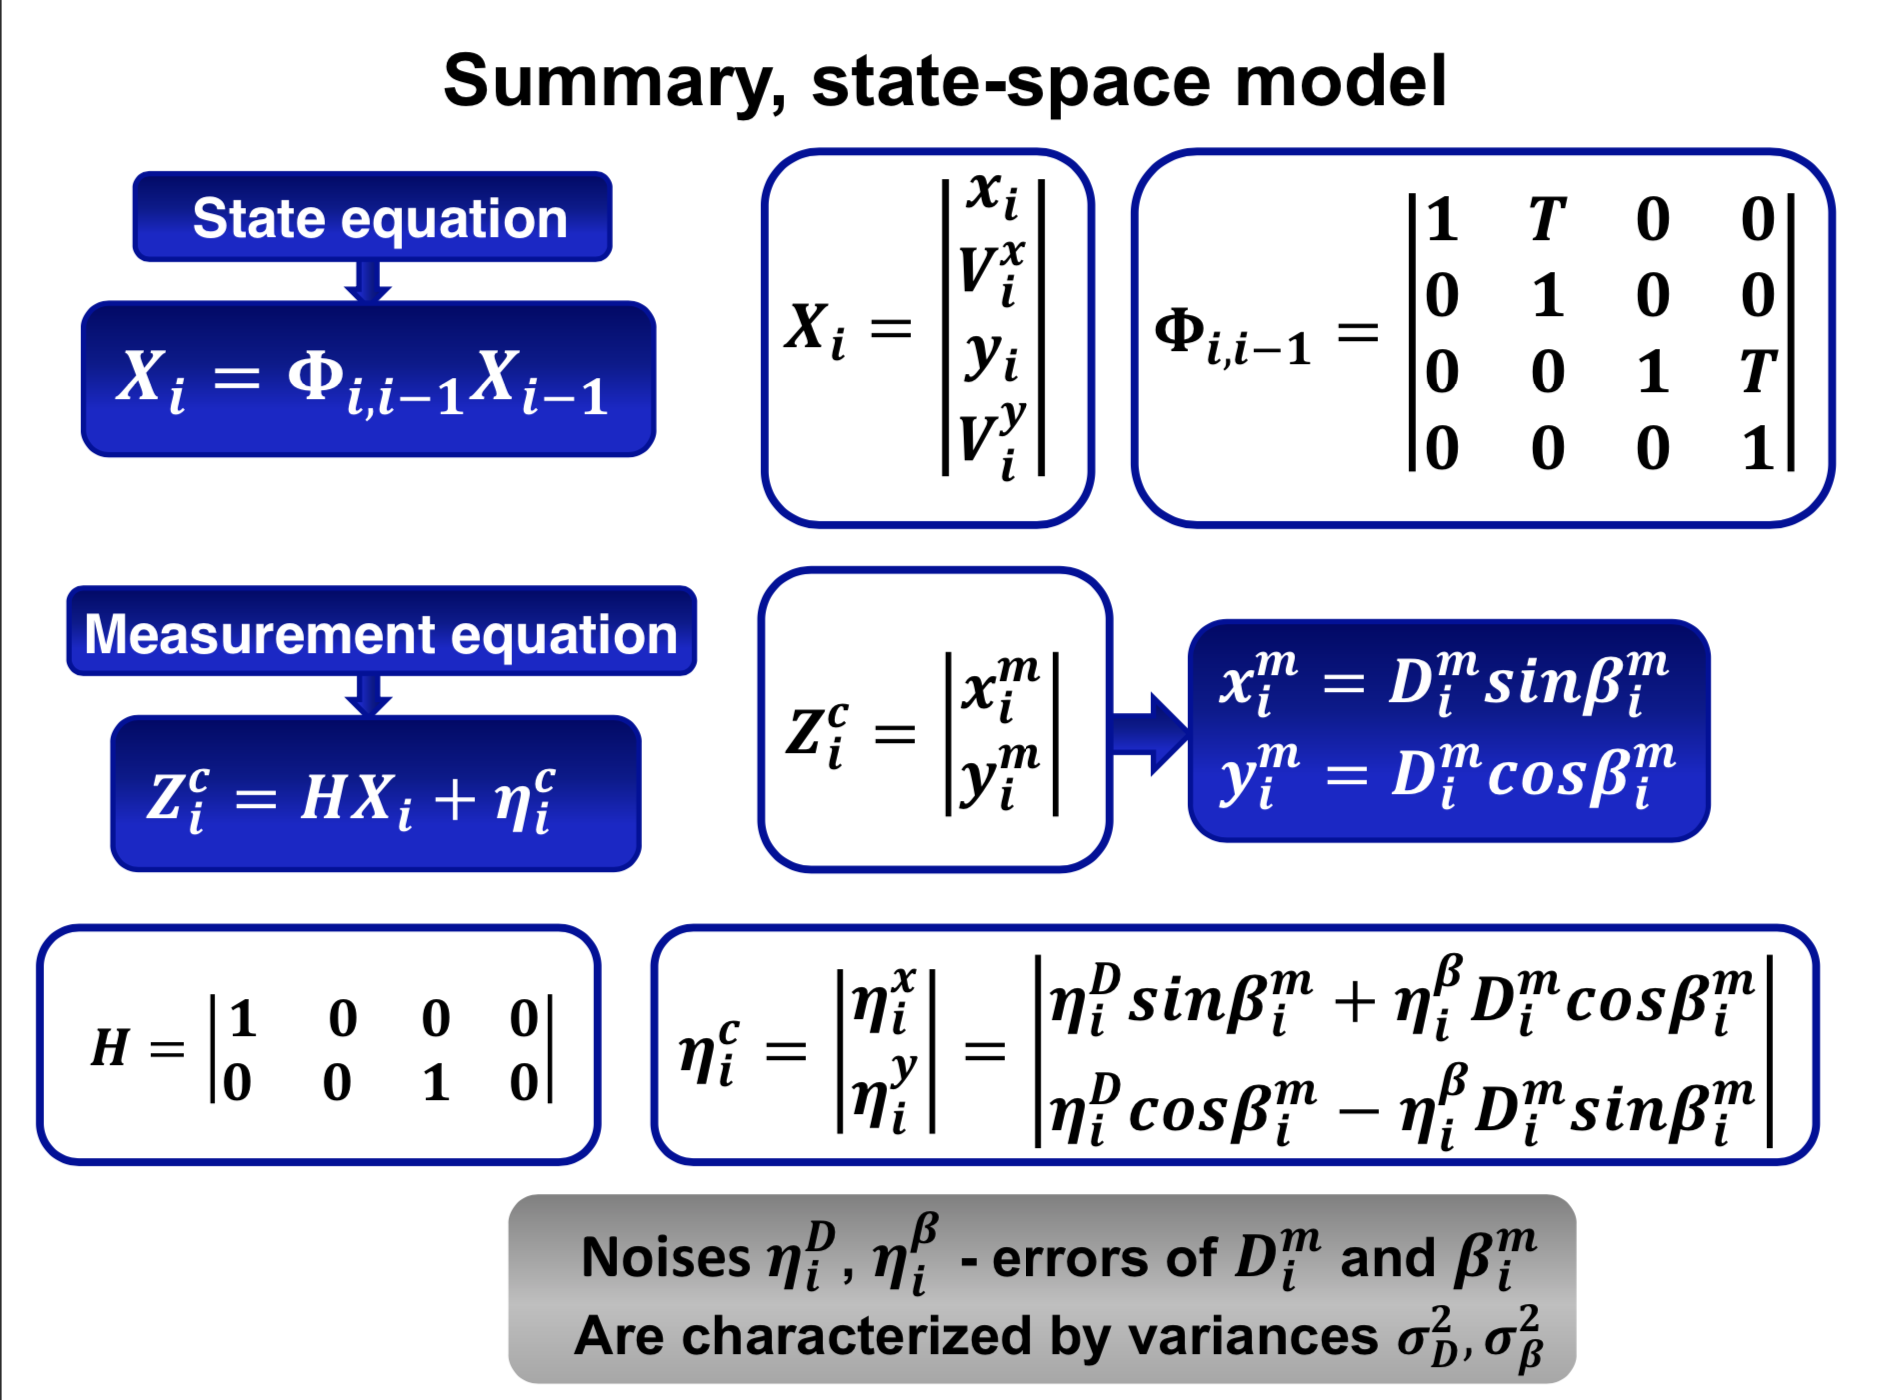

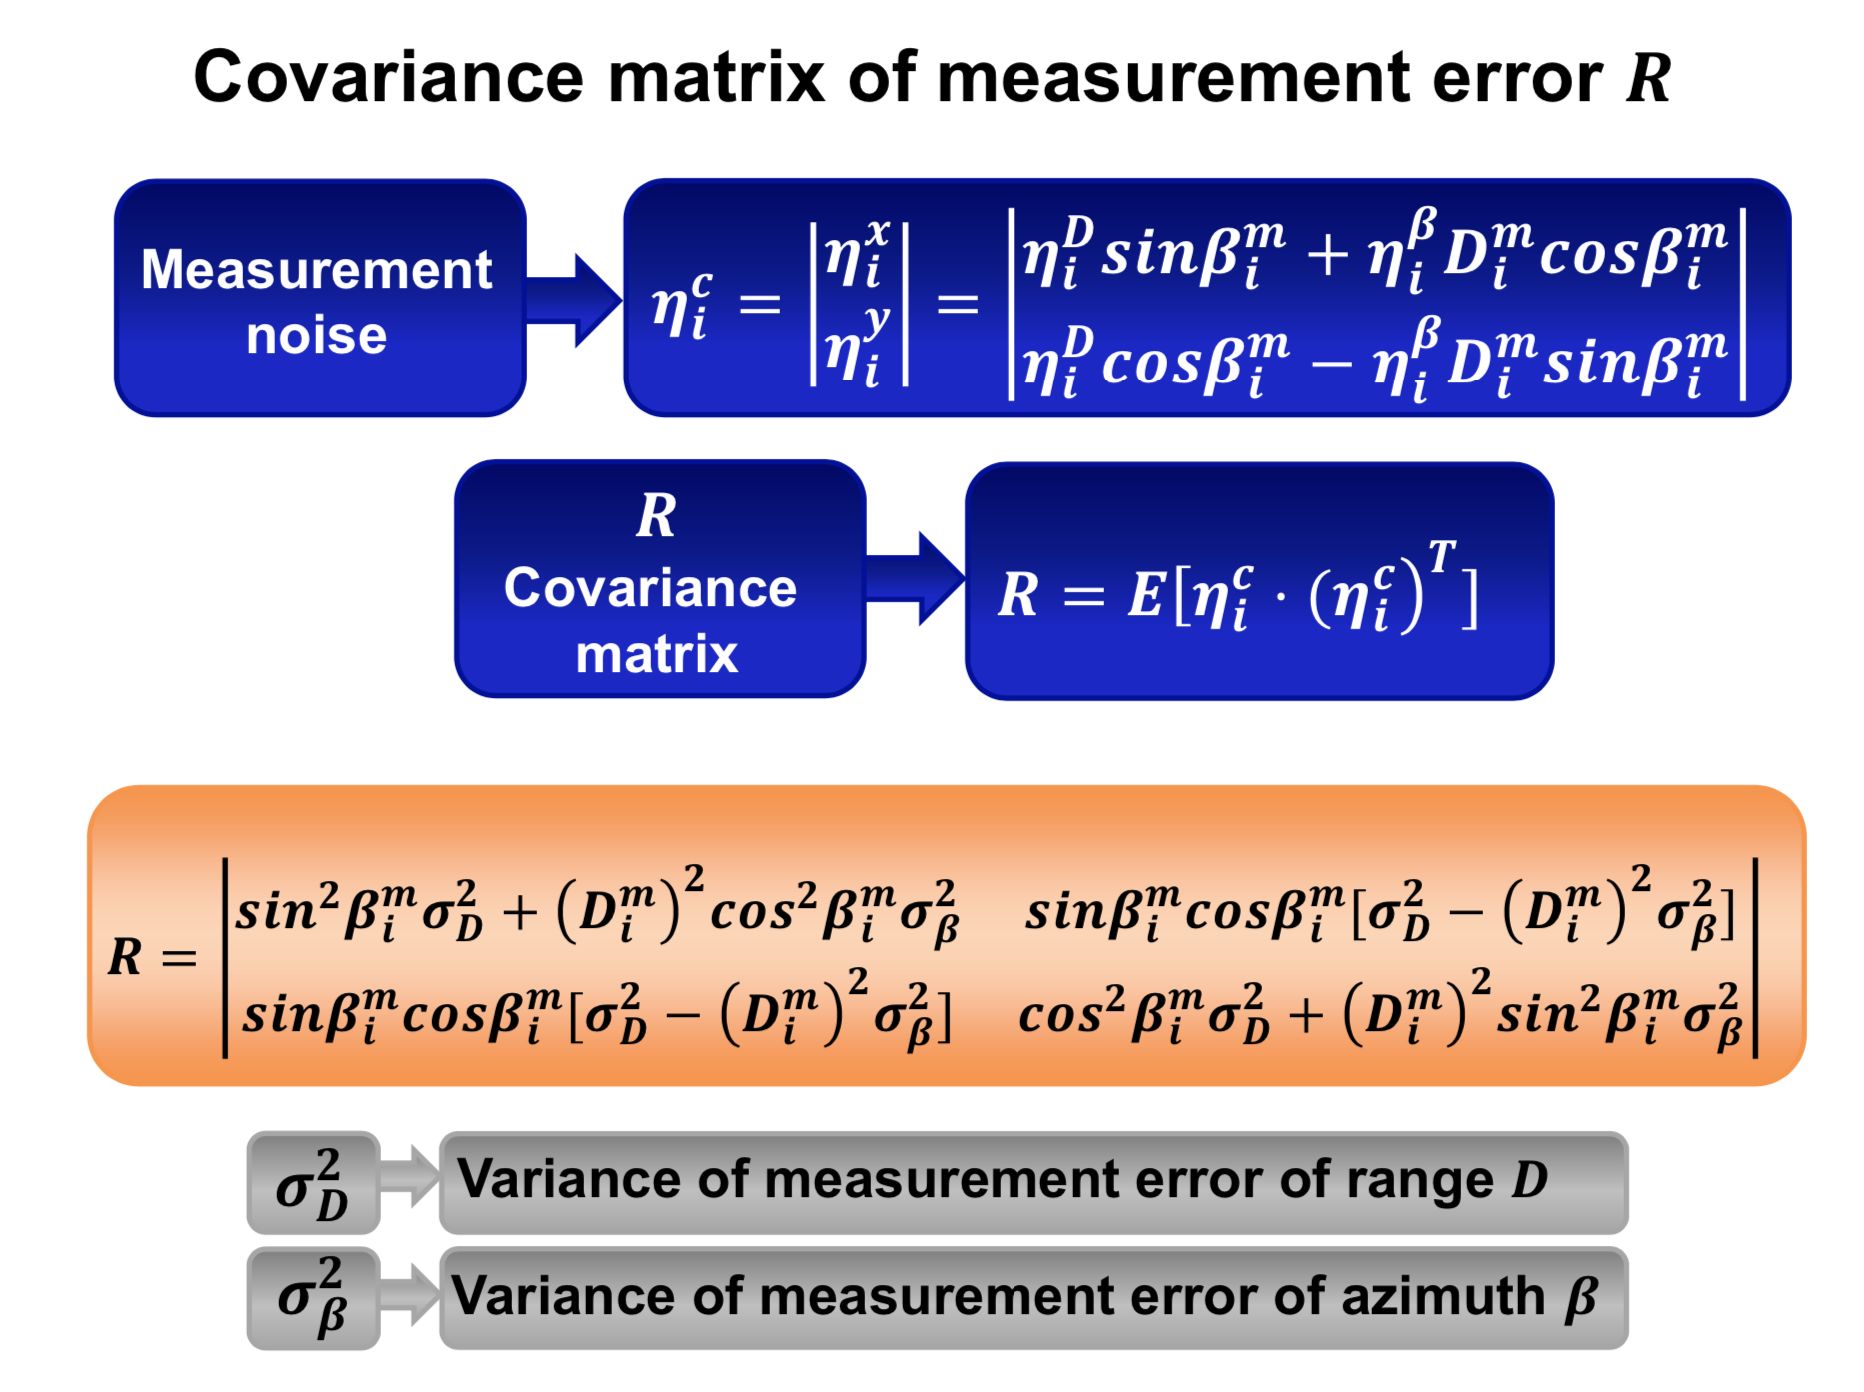

In [17]:
def calculate_R(D_mes, beta_mes, sigma_D = 20, sigma_b = 0.02):
    
    r11 = (np.sin(beta_mes[:]) * sigma_D)**2 + ((D_mes[:])**2)*(np.cos(beta_mes[:])*sigma_b)**2
    r12 = np.sin(beta_mes[:])*np.cos(beta_mes[:])*(sigma_D**2 - ((D_mes[:])**2)*sigma_b**2)
    r21 = np.sin(beta_mes[:])*np.cos(beta_mes[:])*(sigma_D**2 - ((D_mes[:])**2)*sigma_b**2)
    r22 = (np.cos(beta_mes[:]) * sigma_D)**2 + ((D_mes[:])**2)*(np.sin(beta_mes[:])*sigma_b)**2
    return np.column_stack((r11,r12, r21, r22)).reshape((26, 2, 2))

In [18]:
R = calculate_R(D_mes, beta_mes)

In [19]:
def kalman_polar(z, R, T=2, X_0=[40000, -20, 40000, -20], N=26,
                 P_0=np.eye(4)*10**10, sigma_D=2, sigma_b=0.02, shift=7):
    shape = (N, 4)
    X_pred = np.zeros(shape)
    X_filt = np.zeros(shape)
    D_pred = np.zeros(shape[0])
    D_filt = np.zeros(shape[0])
    beta_pred = np.zeros(shape[0])
    beta_filt = np.zeros(shape[0])
    F = np.array([[1, T, 0, 0], 
                  [0, 1, 0, 0], 
                  [0, 0, 1, T], 
                  [0, 0, 0, 1]])
    H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])

    
    # prepare parameters
    P_pred = np.zeros((shape[0], 4, 4))
    P_filt = np.zeros((shape[0], 4, 4))
    K = np.zeros((shape[0], 4, 2))

    X_filt[0] = X_0
    P_filt[0] = P_0
    D_filt[0] = np.sqrt(X_filt[0][0]**2 + X_filt[0][2]**2)
    beta_filt[0] = np.arctan2(X_filt[0][0], X_filt[0][2]) 
    
#     K[0] = P_filt[0].dot(H.T)/(H.dot(P_filt[0]).dot(H.T) + R)

    for i in range(1, shape[0]):
        # Make prediction
        X_pred[i] = F.dot(X_filt[i-1])
        P_pred[i] = np.dot(F, np.dot(P_filt[i-1], F.T))
        D_pred[i] = np.sqrt(X_pred[i][0]**2 + X_pred[i][2]**2)
        beta_pred[i] = np.arctan2(X_pred[i][0], X_pred[i][2]) 

        # Make filtration
        K[i] = P_pred[i].dot(H.T).dot(np.linalg.inv(H.dot(P_pred[i].dot(H.T)) + R[i]))
        X_filt[i] = X_pred[i] + K[i].dot(z[i] - H.dot(X_pred[i]))
        P_filt[i] = (np.eye(shape[1]) - np.dot(K[i], H)).dot(P_pred[i])
        D_filt[i] = np.sqrt(X_filt[i][0]**2 + X_filt[i][2]**2)
        beta_filt[i] = np.arctan2(X_filt[i][0], X_filt[i][2]) 

    return D_filt, beta_filt, D_pred, beta_pred, K, X_filt, X_pred

In [20]:
D_filt, beta_filt, D_pred, beta_pred, K, X_filt, X_pred = kalman_polar(z, R)
plot_polar(3, [D[1:], D_mes[1:], D_filt[1:]],
           [np.degrees(beta[1:]), np.degrees(beta_mes[1:]), np.degrees(beta_filt[1:])],
           legend=['true tr', 'measured tr', 'kalman filter'], size = 1000,
           mode = ['lines', 'markers', 'lines'])

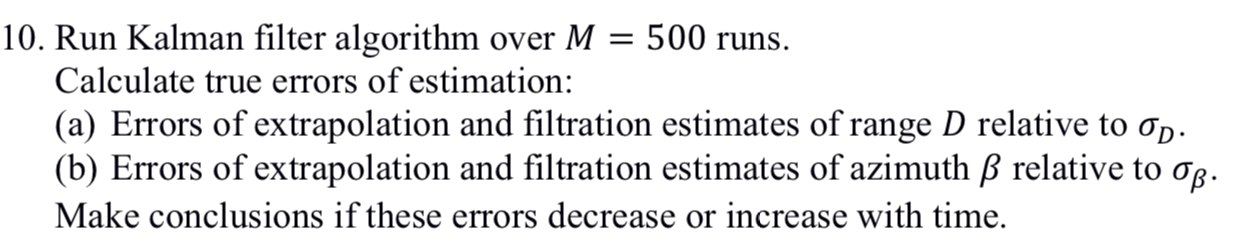

In [21]:
def error_calculation(runs=500, n=26, x0=13500/np.sqrt(2), y0=13500/np.sqrt(2), sigma_D=20, sigma_b=0.02):
    true_err_pred_D = np.zeros(n)
    true_err_pred_beta = np.zeros(n)
    true_err_filt_D = np.zeros(n)
    true_err_filt_beta = np.zeros(n)
    
    for i in range(runs):
        x, Vx, y, Vy = generate_trajectory(x0=x0, y0=y0)
        D, beta = cortes2polar(x, y)
        D_mes, beta_mes = measure_polar_coord(D, beta, sigma_D=sigma_D, sigma_b=sigma_b)
        z = np.column_stack(polar2cartes(D_mes, beta_mes))
        R = calculate_R(D_mes, beta_mes)
        D_filt, beta_filt, D_pred, beta_pred, K, _, _ = kalman_polar(z, R)
        
        true_err_pred_D += (D_pred - D)**2
        true_err_pred_beta += (beta_pred - beta)**2
        true_err_filt_D += (D_filt - D)**2
        true_err_filt_beta += (beta_filt - beta)**2
        
    true_err_pred_D = np.sqrt(true_err_pred_D/(runs-1))
    true_err_pred_beta = np.sqrt(true_err_pred_beta/(runs-1))
    true_err_filt_D = np.sqrt(true_err_filt_D/(runs-1))
    true_err_filt_beta = np.sqrt(true_err_filt_beta/(runs-1))
    
    return true_err_pred_D, true_err_pred_beta, true_err_filt_D, true_err_filt_beta

In [22]:
M = 500
N = 26
true_err_pred_D, true_err_pred_beta, true_err_filt_D, true_err_filt_beta = error_calculation(runs=M, n=N)
steps = np.linspace(1, N, num=N)

In [23]:
plot(3, [steps[3:], steps[3:], steps[3:]], [true_err_pred_D[3:], true_err_filt_D[3:], np.full(N, 20)[3:]],
     legend=['prediction error', 'filtration error', 'range variance'])

In [24]:
plot(3, [steps[3:], steps[3:], steps[3:]], [true_err_pred_beta[3:], true_err_filt_beta[3:], np.full(N, 0.02)[3:]],
     legend=['prediction error', 'filtration error', 'range variance'])

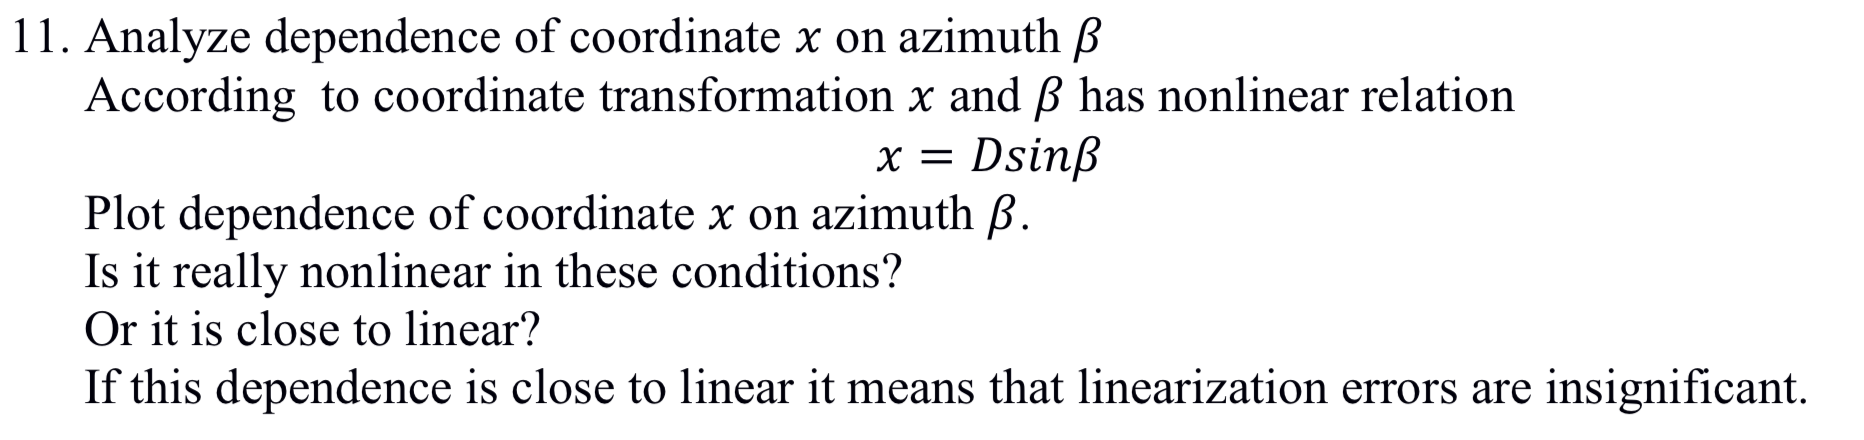

In [25]:
x, Vx, y, Vy = generate_trajectory()
D, beta = cortes2polar(x, y)
D_mes, beta_mes = measure_polar_coord(D, beta)
z = np.column_stack(polar2cartes(D_mes, beta_mes))
R = calculate_R(D_mes, beta_mes)
D_filt, beta_filt, D_pred, beta_pred, K, X_filt, X_pred = kalman_polar(z, R)
plot(1, [beta_filt[3:]], [x[3:]])

In [26]:
X_filt[:, 0]

array([40000.        ,  9605.06415702,  9314.32816722,  9148.52586884,
        9072.75546265,  9047.20909182,  8917.22915793,  8732.78610156,
        8709.89572647,  8517.59211201,  8412.89264182,  8280.30238162,
        8222.69763933,  8160.69101092,  8158.65101812,  8024.29217236,
        7912.7558735 ,  7802.78463166,  7660.92585628,  7565.30512171,
        7549.65146437,  7499.37443843,  7424.43157662,  7248.04655973,
        7131.28606738,  6996.73863873])

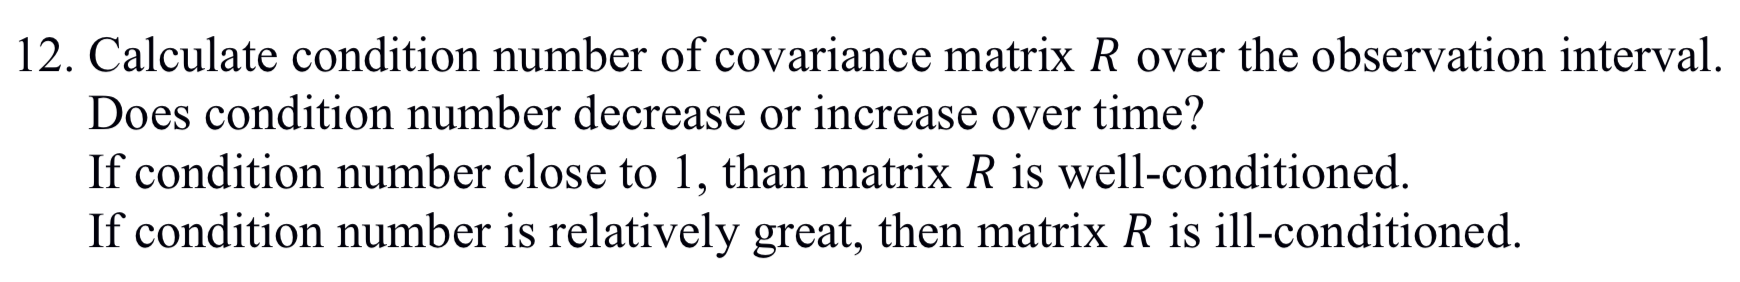

In [27]:
def cond_num(R):
    eigs, v = LA.eig(R)
    out = np.zeros(len(eigs))
    eig1 = eigs[:, 0]
    eig2 = eigs[:, 1]
    for i in range(len(eigs)):
        out[i] = eig1[i]/eig2[i] if eig1[i] > eig2[i] else eig2[i]/eig1[i]
    return out

In [28]:
cond = cond_num(R)
plot(1, [steps], [cond], title='Condition number evolution', xlable='step', ylable='value', legend=['cond num'])

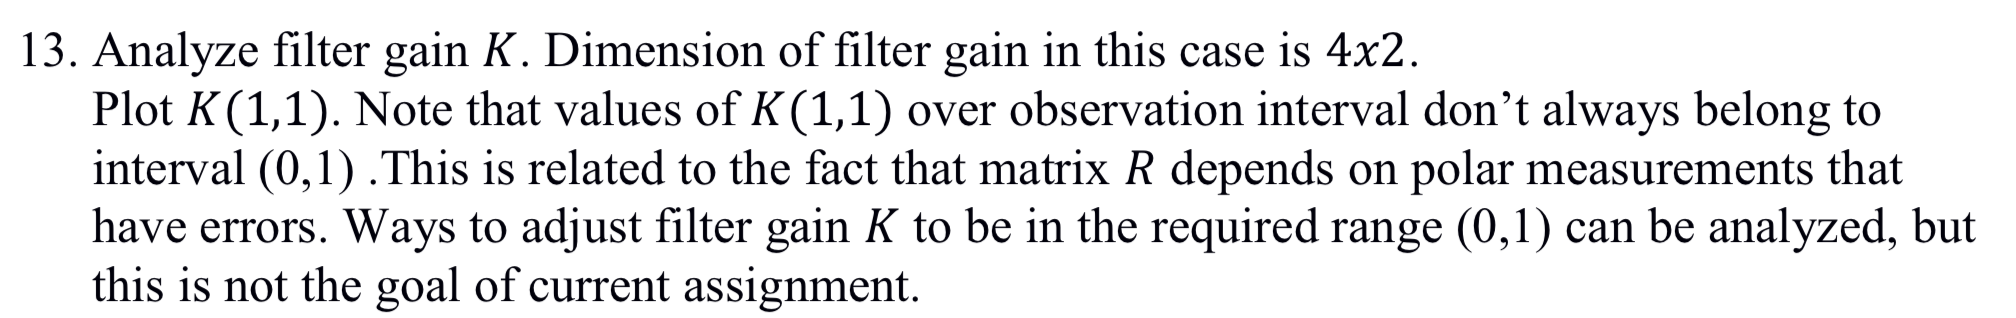

In [31]:
plot(1, [steps], [K[:, 0, 0]])

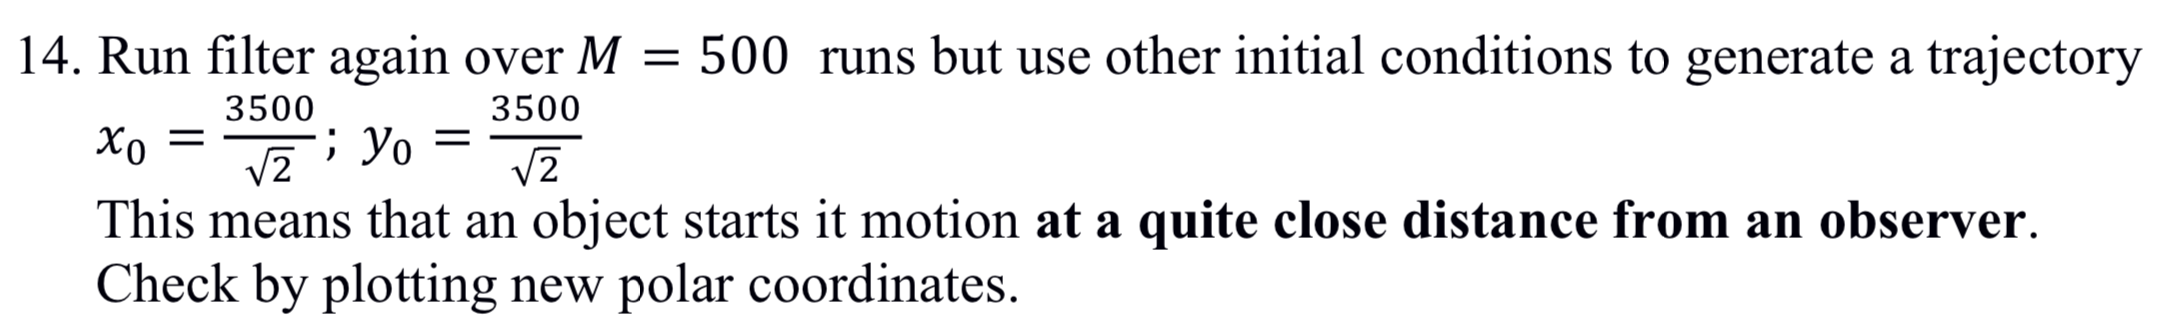

In [32]:
M = 500
N = 26
x0=3500/np.sqrt(2)
y0=3500/np.sqrt(2)
x, Vx, y, Vy = generate_trajectory(x0=x0, y0=y0)
D, beta = cortes2polar(x, y)
D_mes, beta_mes = measure_polar_coord(D, beta)
z = np.column_stack(polar2cartes(D_mes, beta_mes))
R = calculate_R(D_mes, beta_mes)
D_filt, beta_filt, D_pred, beta_pred, K, X_filt, X_pred = kalman_polar(z, R)
plot_polar(3, [D[1:], D_mes[1:], D_filt[1:]],
           [np.degrees(beta[1:]), np.degrees(beta_mes[1:]), np.degrees(beta_filt[1:])],
           legend=['true tr', 'measured tr', 'kalman filter'], size = 1000,
           mode = ['lines', 'markers', 'lines'])

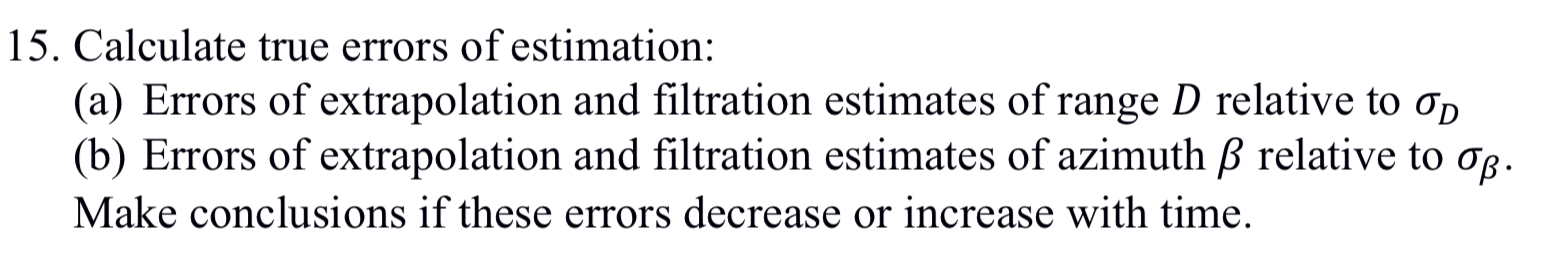

In [33]:
true_err_pred_D, true_err_pred_beta, true_err_filt_D, true_err_filt_beta = error_calculation(runs=M, n=N, 
                                                                                             x0=x0, y0=y0)
steps = np.linspace(1, N, num=N)

In [34]:
plot(3, [steps[3:], steps[3:], steps[3:]], [true_err_pred_D[3:], true_err_filt_D[3:], np.full(N, 20)[3:]],
     legend=['prediction error', 'filtration error', 'range variance'])

In [35]:
plot(3, [steps[3:], steps[3:], steps[3:]], [true_err_pred_beta[3:], true_err_filt_beta[3:], np.full(N, 0.02)[3:]],
     legend=['prediction error', 'filtration error', 'range variance'])

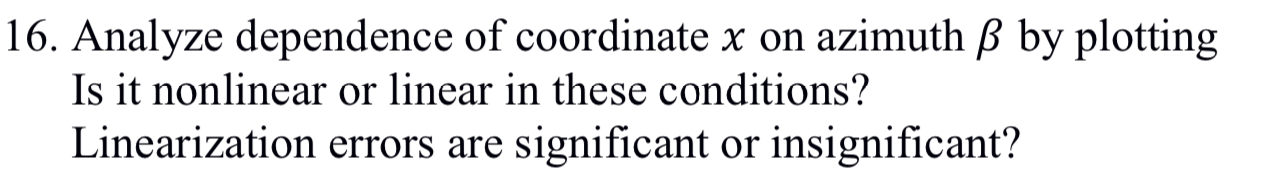

In [36]:
plot(1, [beta_filt[3:]], [x[3:]])

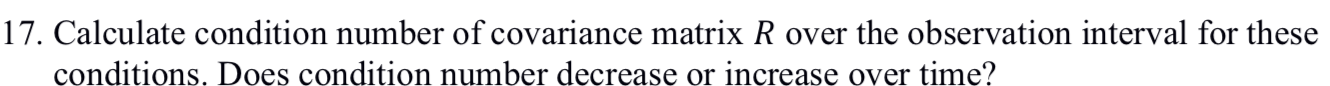

In [37]:
cond = cond_num(R)
plot(2, [steps, steps], [cond, np.full(N, 1)], title='Condition number evolution', xlable='step', ylable='value',
     legend=['cond num', 'referal val'])

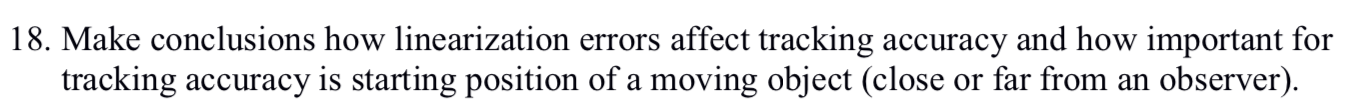

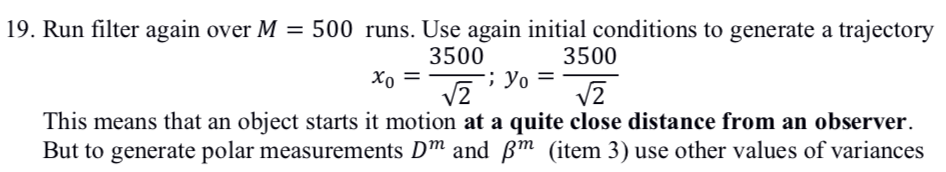

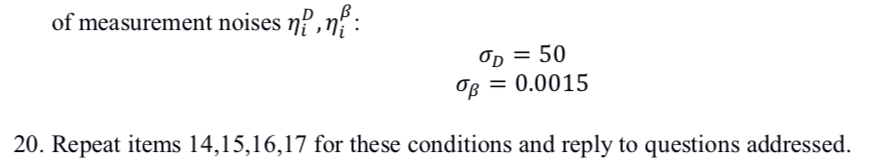

In [39]:
M = 500
N = 26
x0=3500/np.sqrt(2)
y0=3500/np.sqrt(2)
sigma_D=50
sigma_b=0.0015

x, Vx, y, Vy = generate_trajectory(x0=x0, y0=y0)
D, beta = cortes2polar(x, y)
D_mes, beta_mes = measure_polar_coord(D, beta, sigma_D=sigma_D, sigma_b=sigma_b)
z = np.column_stack(polar2cartes(D_mes, beta_mes))
R = calculate_R(D_mes, beta_mes, sigma_D=sigma_D, sigma_b=sigma_b)
D_filt, beta_filt, D_pred, beta_pred, K, X_filt, X_pred = kalman_polar(z, R)
plot_polar(3, [D[1:], D_mes[1:], D_filt[1:]],
           [np.degrees(beta[1:]), np.degrees(beta_mes[1:]), np.degrees(beta_filt[1:])],
           legend=['true tr', 'measured tr', 'kalman filter'], size = 1000,
           mode = ['lines', 'markers', 'lines'])

In [40]:
true_err_pred_D, true_err_pred_beta, true_err_filt_D, true_err_filt_beta = error_calculation(runs=M, n=N, 
                                                                                             x0=x0, y0=y0,
                                                                                             sigma_D=sigma_D,
                                                                                             sigma_b=sigma_b)
steps = np.linspace(1, N, num=N)

In [41]:
plot(3, [steps[3:], steps[3:], steps[3:]], [true_err_pred_D[3:], true_err_filt_D[3:], np.full(N, sigma_D)[3:]],
     legend=['prediction error', 'filtration error', 'range variance'])

In [42]:
plot(3, [steps[3:], steps[3:], steps[3:]], [true_err_pred_beta[3:], true_err_filt_beta[3:], np.full(N, sigma_b)[3:]],
     legend=['prediction error', 'filtration error', 'range variance'])

In [43]:
plot(1, [beta_filt[3:]], [x[3:]])

In [44]:
cond = cond_num(R)
plot(2, [steps, steps], [cond, np.full(N, 1)], title='Condition number evolution', xlable='step', ylable='value',
     legend=['cond num', 'referal val'])